<a href="https://colab.research.google.com/github/kislay960/Data-Science-Practice/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
from keras.datasets import mnist
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential,Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import math
import os
import numpy as np

In [60]:
(X_Train,_),(_,_) = mnist.load_data()

In [61]:
print(X_Train.shape)
print(type(X_Train))

(60000, 28, 28)
<class 'numpy.ndarray'>


In [62]:
#Normalize the Data between -1 and 1
X_Train = (X_Train.astype('float32') - 127.5)/127.5

print(np.min(X_Train))
print(np.max(X_Train))

-1.0
1.0


In [63]:
NUM_EPOCHS = 50
BATCH_SIZE = 256
NO_OF_BATCHES = math.ceil(X_Train.shape[0]/float(BATCH_SIZE))
HALF_BATCH_SIZE = int(BATCH_SIZE/2)

NOISE_DIM = 100

adam = Adam(lr=2e-4,beta_1=0.5)

In [64]:
#Upsampling 
# Start from 7 X 7 X 128
generator = Sequential()
generator.add(Dense(7*7*128,input_shape=(NOISE_DIM,)))
generator.add(Reshape((7,7,128)))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

#Double the Activation Size 14 X 14 X 64
generator.add(UpSampling2D())
generator.add(Convolution2D(64,kernel_size=(5,5),padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

# Double the Activation Size 28 X 28 X 1
generator.add(UpSampling2D())
generator.add(Convolution2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))

# Final Output (No ReLu or Batch Norm)
generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()


#Discriminator - Downsampling
discriminator = Sequential()
discriminator.add(Convolution2D(64,(5,5),strides=(2,2),padding='same',input_shape=(28,28,1)))
discriminator.add(LeakyReLU(0.2))

# Prefer Strided Convolutions over MaxPooling
discriminator.add(Convolution2D(128,(5,5),strides=(2,2),padding='same'))
discriminator.add(LeakyReLU(0.2))


discriminator.add(Flatten())
discriminator.add(Dense(1,activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy',optimizer=adam)
discriminator.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 14, 14, 64)       

In [65]:
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))
generated_img = generator(gan_input)
gan_output = discriminator(generated_img)

#Functional API
model = Model(gan_input,gan_output)
model.compile(loss='binary_crossentropy',optimizer=adam)

def save_imgs(epoch,samples=100):
    noise = np.random.normal(0,1,size=(samples,NOISE_DIM))
    generated_imgs = generator.predict(noise)
    generated_imgs = generated_imgs.reshape(samples,28,28)
    
    plt.figure(figsize=(10,10))
    for i in range(samples):
        plt.subplot(10,10,i+1)
        plt.imshow(generated_imgs[i],interpolation='nearest',cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    out_path = '/content/images/gan_output_epoch_'
    out_dir = os.path.dirname(out_path)
    plt.savefig(out_dir+'{0}.png'.format(epoch+1))
    plt.show()

In [66]:
X_Train = X_Train.reshape((60000,28,28,1))
X_Train.shape

(60000, 28, 28, 1)

Epoch 1 D loss: 138.415097 G loss: 169.325419
Epoch 2 D loss: 176.139198 G loss: 208.002575
Epoch 3 D loss: 162.862085 G loss: 213.081093
Epoch 4 D loss: 160.130903 G loss: 210.544202
Epoch 5 D loss: 164.444289 G loss: 197.213022
Epoch 6 D loss: 163.629127 G loss: 196.870793
Epoch 7 D loss: 162.952176 G loss: 196.139693
Epoch 8 D loss: 162.081693 G loss: 198.746058
Epoch 9 D loss: 161.879660 G loss: 196.529821
Epoch 10 D loss: 161.732139 G loss: 195.484587


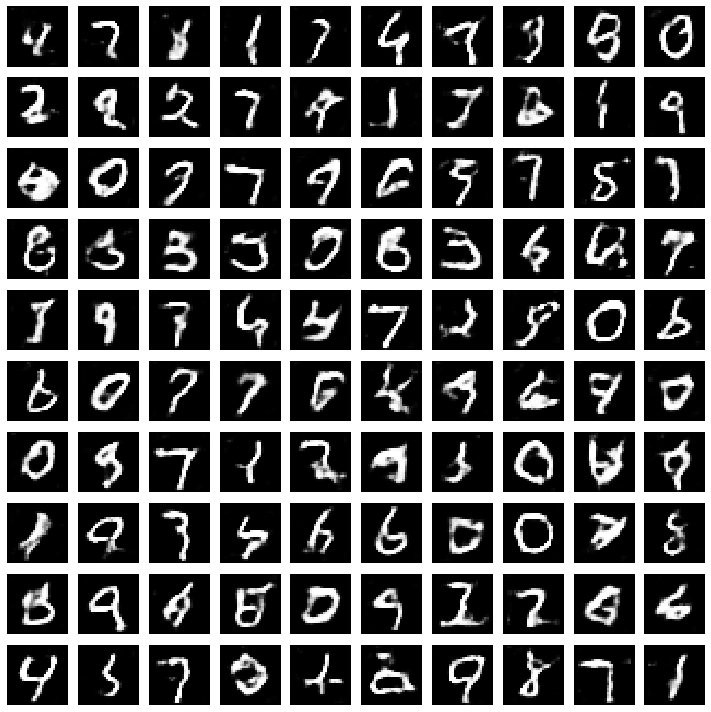

Epoch 11 D loss: 161.121594 G loss: 198.651638
Epoch 12 D loss: 161.184600 G loss: 196.198840
Epoch 13 D loss: 161.269565 G loss: 196.095135
Epoch 14 D loss: 160.636504 G loss: 200.726667
Epoch 15 D loss: 160.969817 G loss: 196.862539
Epoch 16 D loss: 160.821104 G loss: 197.286373
Epoch 17 D loss: 160.385503 G loss: 201.806601
Epoch 18 D loss: 160.469634 G loss: 198.855440
Epoch 19 D loss: 160.576525 G loss: 197.585351
Epoch 20 D loss: 160.498159 G loss: 198.027810


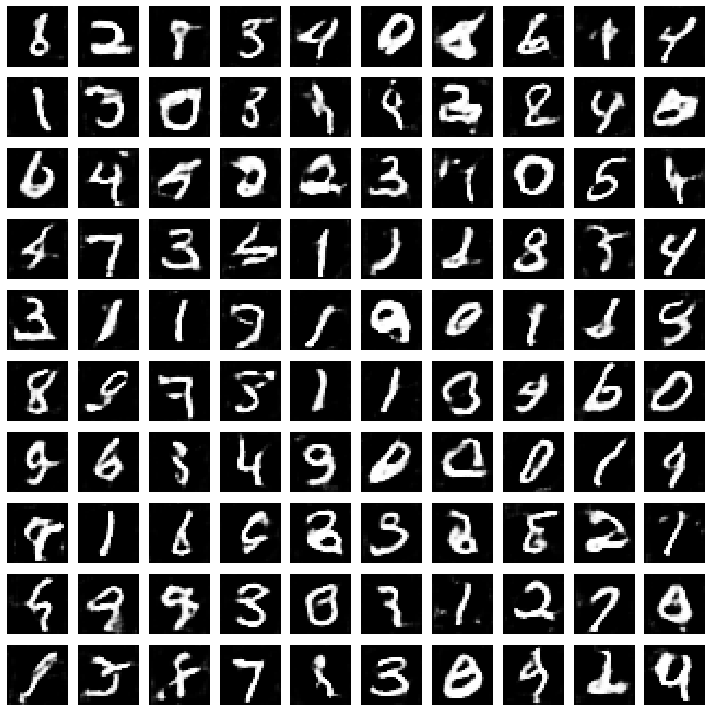

In [ ]:
for epoch in range(NUM_EPOCHS):
    epoch_d_loss = 0.
    epoch_g_loss = 0.
    
    for step in range(NO_OF_BATCHES):
        #randomly select 50% real images
        idx = np.random.randint(0,X_Train.shape[0],HALF_BATCH_SIZE)
        real_imgs = X_Train[idx]
        
        # generate 50% random images
        noise = np.random.normal(0,1,size=(HALF_BATCH_SIZE,NOISE_DIM))
        fake_imgs = generator.predict(noise)
        
        
        # one sided label smoothing
        real_y = np.ones((HALF_BATCH_SIZE,1))*0.9 #Label Smoothing, Works well in practice
        fake_y = np.zeros((HALF_BATCH_SIZE,1))
        
        # train on real and fake images
        d_loss_real = discriminator.train_on_batch(real_imgs,real_y) #updates the weights of discriminator
        d_loss_fake = discriminator.train_on_batch(fake_imgs,fake_y) 
        d_loss = 0.5*d_loss_real + 0.5*d_loss_fake
        
        epoch_d_loss += d_loss
        
        #Train Generator (Complete Model Generator + Frozen Discriminator)
        
        noise = np.random.normal(0,1,size=(BATCH_SIZE,NOISE_DIM))
        real_y = np.ones((BATCH_SIZE,1))
        g_loss = model.train_on_batch(noise,real_y)
        epoch_g_loss += g_loss
        
    print("Epoch %d D loss: %f G loss: %f" % ((epoch + 1), epoch_d_loss, epoch_g_loss))

    if (epoch+1)%10==0:
        output_path = '/content/models/gan_generator_'
        output_dir = os.path.dirname(output_path)
        generator.save(output_dir+'{0}.h5'.format(epoch+1))
        save_imgs(epoch)

In [ ]:
from google.colab import files
for i in range(10,51,10):
    files.download('/content/images{}.png'.format(i))